In [29]:
import gzip
import collections
from sklearn import linear_model
from sklearn import metrics
import random
import numpy as np
import string
import math
import re
from nltk.stem.porter import *
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import csv

In [2]:
# Helper Methods
def readGz(path):
    for l in gzip.open(path, 'rt', encoding='utf-8'):
        if 'null' not in l:
            yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

In [3]:
# renttherunway
print('start')
clothing = list(readGz("renttherunway_final_data.json.gz"))
print('done')

start
done


In [286]:
clothing[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

In [287]:
len(clothing)

192462

In [4]:
cloth = []
for item in clothing:
    if len(item.keys()) == 15:
        cloth.append(item)
len(cloth)

146381

In [5]:
userdict = defaultdict(list)
for item in cloth:
    userdict[item['user_id']].append(item['item_id'])

In [6]:
len(userdict)

77347

In [7]:
tr = cloth[:117105]
va = cloth[117105:131743]
te = cloth[131743:]

In [292]:
bra = set()
for item in cloth:
    bra.add(item['body type'])
bra

{'apple',
 'athletic',
 'full bust',
 'hourglass',
 'pear',
 'petite',
 'straight & narrow'}

In [8]:
def build_feature(item):
    # fit
    fit = -1
    if item['fit'] == 'small':
        fit = 0
    elif item['fit'] == 'fit':
        fit = 1
    else:
        fit = 2
    
    # bra
    bra = int(item['bust size'][:2])
    cup = ord(item['bust size'][2])
    
    # weight
    weight = int(item['weight'][:-3])
    
    # rating
    rating = int(item['rating'])
    
    # height
    feetinch = re.findall(r'\d+', item['height'])
    height = int(feetinch[0]) * 12 + int(feetinch[1])
    
    # size
    size = item['size']
    
    # age
    age = int(item['age'])
    
    # rented for
    rf = item['rented for']
    rf_dict = {'date':0, 'everyday':1, 'formal affair':2, 'other':3, 'party':4, 'party: cocktail':5, 'vacation':6, \
               'wedding':7, 'work':8}
    rf = rf_dict[rf]
    
    # body type
    bt = item['body type']
    bt_dict = {'apple':0, 'athletic':1, 'full bust':2, 'hourglass':3, 'pear':4, 'petite':5, 'straight & narrow':6}
    bt = bt_dict[bt]
    
    return [1, bra, cup, weight, height, size, age, rating, rf, bt], fit

In [9]:
tr_X = []
va_X = []
te_X = []
tr_y = []
va_y = []
te_y = []
for item in tr:
    X, y = build_feature(item)
    tr_X.append(X)
    tr_y.append(y)
for item in va:
    X, y = build_feature(item)
    va_X.append(X)
    va_y.append(y)
for item in te:
    X, y = build_feature(item)
    te_X.append(X)
    te_y.append(y)

In [297]:
mod = linear_model.LogisticRegression(C=1)
mod.fit(tr_X, tr_y)
pred = mod.predict(te_X)
count = 0
for i in range(len(pred)):
    if pred[i] == te_y[i]:
        count += 1

print("when C is 1", ", accuracy is:", count / len(pred))

when C is 1 , accuracy is: 0.7344582593250444


In [54]:
# Helper Method
punctuation = set(string.punctuation)
def proc_review(review):
    r = ''.join([c for c in review.lower() if not c in punctuation])
    return r

In [55]:
reviews = []
for item in cloth:
    reviews.append(proc_review(item['review_text']))

In [300]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(reviews)

In [301]:
X = X.A
feats = []
for row in X:
    feats.append([1] + row.tolist())

In [302]:
tr_tfidf = feats[:117105]
va_tfidf = feats[117105:131743]
te_tfidf = feats[131743:]

In [303]:
mod = linear_model.LogisticRegression(C=10)
mod.fit(tr_tfidf, tr_y)
pred = mod.predict(te_tfidf)
count = 0
for i in range(len(pred)):
    if pred[i] == te_y[i]:
        count += 1

print("when C is 10", ", accuracy is:", count / len(pred))

when C is 10 , accuracy is: 0.7987429976772783


In [305]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(reviews)
X = X.A
i = 0
feats = []
all_X = tr_X + va_X + te_X
for row in X:
    feats.append(all_X[i] + row.tolist())
    i += 1

In [306]:
tr_comb = feats[:117105]
va_comb = feats[117105:131743]
te_comb = feats[131743:]

In [307]:
mod = linear_model.LogisticRegression(C=100)
mod.fit(tr_comb, tr_y)
pred = mod.predict(te_comb)
count = 0
for i in range(len(pred)):
    if pred[i] == te_y[i]:
        count += 1

print("when C is 100", ", accuracy is:", count / len(pred))

when C is 100 , accuracy is: 0.8095368219702145


In [309]:
# trivial predictor
count = 0
for y in tr_y + va_y + te_y:
    if y == 1:
        count += 1
count / 146381

0.7359766636380405

In [322]:
# baseline
predictions = []
for r in reviews[131743:]:
    if ('small' in r):
        predictions.append(0)
    elif ('large' in r):
        predictions.append(2)
    else:
        predictions.append(1)

count = 0
for i in range(len(predictions)):
    if predictions[i] == te_y[i]:
        count += 1

print("baseline accuracy:", count / len(predictions))

baseline accuracy: 0.7063123377510588


### Explore Dataset

In [16]:
# count fit
fitdict = defaultdict(int)
for item in cloth:
    if item['fit'] == 'small':
        fitdict['small'] += 1
    elif item['fit'] == 'large':
        fitdict['large'] += 1
    elif item['fit'] == 'fit':
        fitdict['fit'] += 1
    else:
        print('Other Category')
        
# count ratings
ratingdict = defaultdict(int)
for item in cloth:
    ratingdict[int(item['rating'])] += 1

In [17]:
fitdict

defaultdict(int, {'fit': 107733, 'small': 19622, 'large': 19026})

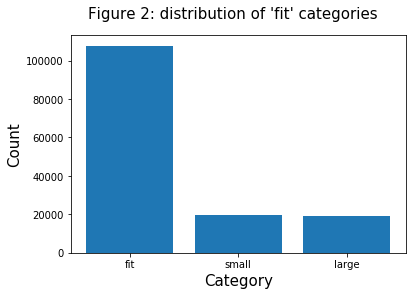

In [111]:
fig = plt.figure()
fig.suptitle('Figure 2: distribution of \'fit\' categories', fontsize=15)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.bar(range(len(fitdict)), list(fitdict.values()), align='center')
plt.xticks(range(len(fitdict)), list(fitdict.keys()))
plt.show()

In [19]:
ratingdict

defaultdict(int, {10: 94291, 8: 40761, 4: 2205, 6: 8341, 2: 783})

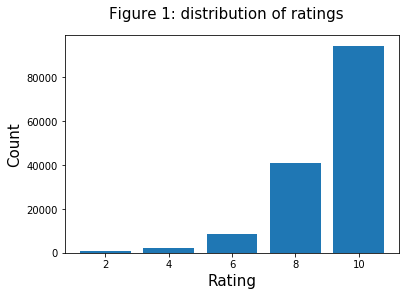

In [110]:
od = collections.OrderedDict(sorted(ratingdict.items()))
fig2 = plt.figure()
fig2.suptitle('Figure 1: distribution of ratings', fontsize=15)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.bar(range(len(od)), list(od.values()), align='center')
plt.xticks(range(len(od)), list(od.keys()))
plt.show()

In [68]:
94291/sum(fitdict.values())

0.6441478060677274

In [92]:
random.shuffle(reviews)

In [93]:
s_reviews = random.sample(reviews, 10000)

In [94]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = ' '
stopwords = set(STOPWORDS) 

for r in s_reviews:
    comment_words += r

In [108]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, collocations=False,
                min_font_size = 10).generate(comment_words)

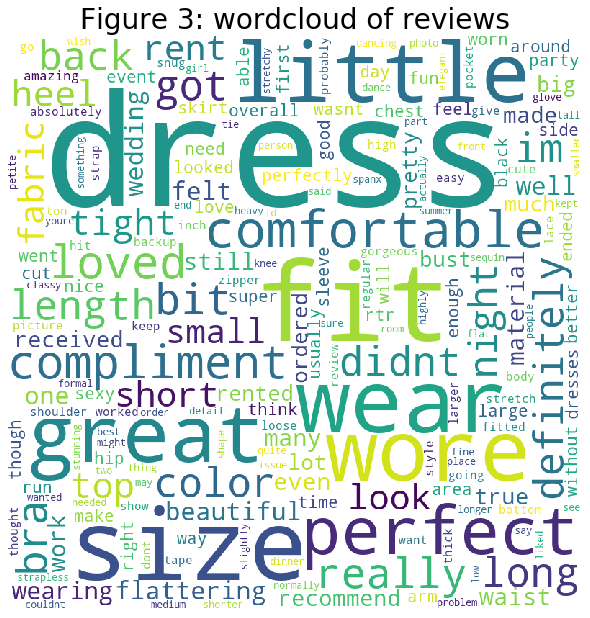

In [112]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Figure 3: wordcloud of reviews', fontdict = {'fontsize' : 28})
  
plt.show() 

### Rating Prediction

In [51]:
def build_feature_rating(item):
    # fit
    fit = item['fit']
    if fit == 'small':
        fit = 0
    elif fit == 'fit':
        fit = 1
    else:
        fit = 2
    
    # bra
    bra = int(item['bust size'][:2])
    cup = ord(item['bust size'][2])
    
    # weight
    weight = int(item['weight'][:-3])
    
    # rating
    rating = int(item['rating'])
    
    # height
    feetinch = re.findall(r'\d+', item['height'])
    height = int(feetinch[0]) * 12 + int(feetinch[1])
    
    # size
    size = item['size']
    
    # age
    age = int(item['age'])
    
    # rented for
    rf = item['rented for']
    rf_dict = {'date':0, 'everyday':1, 'formal affair':2, 'other':3, 'party':4, 'party: cocktail':5, 'vacation':6, \
               'wedding':7, 'work':8}
    rf = rf_dict[rf]
    
    # body type
    bt = item['body type']
    bt_dict = {'apple':0, 'athletic':1, 'full bust':2, 'hourglass':3, 'pear':4, 'petite':5, 'straight & narrow':6}
    bt = bt_dict[bt]
    
    return [1, fit, bra, cup, weight, height, size, age, rf, bt], rating

In [56]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(reviews)
X = X.A
i = 0
feats = []
ratings = []
for row in X:
    f, y = build_feature_rating(cloth[i])
    feats.append(f + row.tolist())
    ratings.append(y)
    i += 1
    
tr_feats = feats[:117105]
va_feats = feats[117105:131743]
te_feats = feats[131743:]

tr_ratings = ratings[:117105]
va_ratings = ratings[117105:131743]
te_ratings = ratings[131743:]

In [57]:
# regularized regression
clf = linear_model.Ridge(0.1, fit_intercept=False)
clf.fit(tr_feats, tr_ratings)
theta = clf.coef_
predictions = clf.predict(te_feats)

mse = metrics.mean_squared_error(predictions, te_ratings)
print("when c is 0.1", ", MSE is", mse)

when c is 0.1 , MSE is 1.4879801746499521


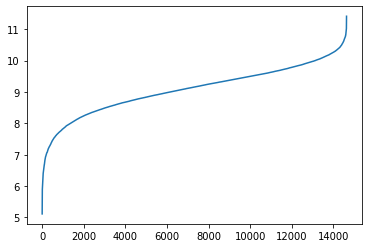

In [61]:
predictions.sort()
plt.plot(predictions)

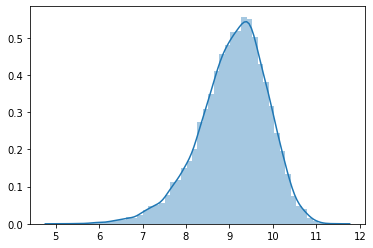

In [66]:
import seaborn as sns
sns.distplot(predictions)